<a href="https://colab.research.google.com/github/zohaibmukhtarbhatti-del/Financial-News-Sentiment-Analyzer/blob/main/NEWS_Sentiment_and_Stock_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##📘 Project: News Sentiment and Stock Correlation
### Name: Zohaib Mukhtar
###Topic: News Sentiment Analysis & Stock Movement Correlation
###Dataset: Massive Stock News Analysis DB for NLPBacktests


##🛠️ Section 1: Setup and Data Loading
First, we need to import the necessary libraries and load the dataset.
###Step 1.1: Import Libraries

In [2]:
!pip install gensim spacy scikit-learn nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 69.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec, FastText

# Download necessary NLTK and SpaCy data
nltk.download('stopwords')
nltk.download('punkt')
# Ensure spacy model is downloaded (run '!python -m spacy download en_core_web_sm' in terminal if needed)
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print("Downloading SpaCy model...")
    !python -m spacy download en_core_web_sm
    nlp = spacy.load('en_core_web_sm')

print("Libraries imported successfully.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Libraries imported successfully.


##Load Dataset

In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
import os

miguelaenlle_massive_stock_news_analysis_db_for_nlpbacktests_path = kagglehub.dataset_download('miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests')

# Construct the full path to the CSV file
# Based on the directory contents, 'raw_partner_headlines.csv' appears to be the relevant news data.
file_path = os.path.join(miguelaenlle_massive_stock_news_analysis_db_for_nlpbacktests_path, 'raw_partner_headlines.csv')

# Load the dataset into a pandas DataFrame
df = pd.read_csv(file_path)

print('Data source import complete.')

Using Colab cache for faster access to the 'massive-stock-news-analysis-db-for-nlpbacktests' dataset.
Data source import complete.


##📊 Section 2: Exploratory Data Analysis (EDA)
We will now perform the initial analysis to understand the data structure and quality.
###2.1 Dataset Overview
Checking the shape, input variables, and target variables

In [5]:
print("--- Dataset Overview ---")
print(f"Total Rows: {df.shape[0]}")
print(f"Total Columns: {df.shape[1]}")
print("\nColumn Info:")
print(df.info())

# Identify potential Input (Text) and Target (Label) columns
# Adjust 'title' and 'sentiment' based on your actual column names
print("\n--- Sample Data ---")
display(df.head(3))

--- Dataset Overview ---
Total Rows: 1845559
Total Columns: 6

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1845559 entries, 0 to 1845558
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   headline    object
 2   url         object
 3   publisher   object
 4   date        object
 5   stock       object
dtypes: int64(1), object(5)
memory usage: 84.5+ MB
None

--- Sample Data ---


,Unnamed: 0,headline,url,publisher,date,stock
0,2,Agilent Technologies Announces Pricing of $5……...,http://www.gurufocus.com/news/1153187/agilent-...,GuruFocus,2020-06-01 00:00:00,A
1,3,Agilent (A) Gears Up for Q2 Earnings: What's i...,http://www.zacks.com/stock/news/931205/agilent...,Zacks,2020-05-18 00:00:00,A
2,4,J.P. Morgan Asset Management Announces Liquida...,http://www.gurufocus.com/news/1138923/jp-morga...,GuruFocus,2020-05-15 00:00:00,A


###2.2 Data Quality Checks
Checking for missing values, duplicates, and irrelevant fields.

In [6]:
print("--- Data Quality Checks ---")

# 1. Missing Values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# 2. Duplicates
duplicates = df.duplicated().sum()
print(f"\nTotal Duplicate Rows: {duplicates}")

# 3. Class Balance (assuming a 'sentiment' or similar label column exists)
# If your dataset doesn't have a label yet, skip this or use a ticker column
target_col = 'sentiment' # REPLACE with your actual target column name if available
if target_col in df.columns:
    print(f"\nClass Distribution in '{target_col}':")
    print(df[target_col].value_counts())
else:
    print(f"\nColumn '{target_col}' not found. Please define your target variable.")

--- Data Quality Checks ---

Missing Values per Column:
Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

Total Duplicate Rows: 0

Column 'sentiment' not found. Please define your target variable.


###2.3 Basic Visualizations
Visualizing text length distribution and label counts.

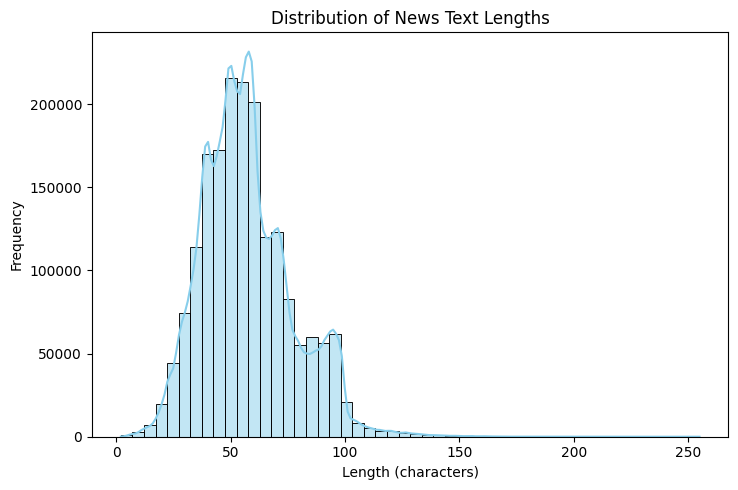

In [8]:
# Create a temporary column for text length
# Replace 'title' with the column containing the news text
text_col = 'headline'

if text_col in df.columns:
    df['text_length'] = df[text_col].astype(str).apply(len)

    # Visualization
    plt.figure(figsize=(14, 5))

    # Histogram of Text Lengths
    plt.subplot(1, 2, 1)
    sns.histplot(df['text_length'], bins=50, kde=True, color='skyblue')
    plt.title('Distribution of News Text Lengths')
    plt.xlabel('Length (characters)')
    plt.ylabel('Frequency')

    # Bar Chart of Label Distribution
    if target_col in df.columns:
        plt.subplot(1, 2, 2)
        sns.countplot(x=target_col, data=df, palette='viridis')
        plt.title('Label Distribution')
        plt.xlabel('Sentiment/Class')
        plt.ylabel('Count')

    plt.tight_layout()
    plt.show()
else:
    print(f"Text column '{text_col}' not found.")

##📝 Section 3: Preprocessing Plan (Markdown Report)
In this section, we summarize the preprocessing strategy identified via GPT analysis.
###Step 2 – Preprocessing Identification Report
####Summary of Recommended Steps:
Based on the dataset characteristics (News Headlines/Financial Text) and GPT recommendations, the following pipeline is established:
###Text Cleaning:
HTML/URLs: Remove to eliminate non-semantic web markup.
Source Attributions: Remove patterns like "Reuters -", "AP -" as they introduce bias towards the publisher rather than the content.
Special Characters: Remove everything except periods and commas to maintain sentence structure while removing noise.
Contractions: Expand (e.g., "won't" -> "will not") for consistency.
###Normalization:
Lowercasing: Convert all text to lowercase. Note: As per project guidelines, Named Entity capitalization is ignored in favor of model pattern learning.
Lemmatization: Apply spaCy lemmatization. This is preferred over stemming (Porter/Snowball) because it reduces words to their dictionary root (lemma) based on context, which is crucial for financial sentiment accuracy.
###Stopword Removal:
Remove standard English stopwords (e.g., "the", "is") using NLTK to reduce dimensionality and focus on content words.
###Tokenization Strategy:
Word-level Tokenization: Selected using spaCy. This is appropriate for Word2Vec/FastText training and standard LSTM models.
##🧹 Section 4: Preprocessing Implementation
Here we implement the cleaning functions defined in the plan.

In [9]:
import spacy
import re
from tqdm import tqdm  # Progress bar library

# 1. Load SpaCy with only necessary components (Disable NER and Parser for speed)
# We only need the tagger for lemmatization
try:
    nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
except OSError:
    print("Downloading SpaCy model...")
    !python -m spacy download en_core_web_sm
    nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

# 2. Faster Regex Cleaning Function
def quick_clean(text):
    if not isinstance(text, str): return ""
    # Combined regex for speed
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # URLs
    text = re.sub(r'<.*?>', '', text)  # HTML
    text = re.sub(r'[^a-zA-Z0-9\s.,]', '', text)  # Special chars
    text = re.sub(r'\s+', ' ', text).strip()  # Whitespace
    return text.lower()

# 3. Check Dataset Size
print(f"Total rows to process: {len(df)}")

# OPTIONAL: If dataset is > 100,000 rows and you are in a rush,
# uncomment the line below to use a sample first!
# df = df.sample(n=50000, random_state=42).copy()

# 4. Apply Regex Cleaning First (Fast)
print("Step 1/2: Cleaning text (Regex)...")
# Make sure to use the correct column name you found earlier (e.g., 'title' or 'headline')
text_col = 'headline'  # <--- VERIFY THIS NAME MATCHES YOUR DATA
df['clean_text'] = df[text_col].astype(str).apply(quick_clean)

# 5. Apply SpaCy Lemmatization using nlp.pipe (Batch Processing)
print("Step 2/2: Tokenizing & Lemmatizing (this may still take a few minutes)...")

batch_size = 2000
processed_tokens = []

# Use nlp.pipe for high-speed batch processing
# n_process=1 is safer on Windows/some local setups. If on Mac/Linux, you can try n_process=2
for doc in tqdm(nlp.pipe(df['clean_text'], batch_size=batch_size), total=len(df)):
    # Extract lemmas for words that are not stopwords and length >= 3
    tokens = [token.lemma_ for token in doc if not token.is_stop and len(token.text) >= 3]
    processed_tokens.append(tokens)

# Assign back to DataFrame
df['processed_tokens'] = processed_tokens
df['processed_text'] = df['processed_tokens'].apply(lambda x: ' '.join(x))

print("✅ Preprocessing Complete!")
display(df[['processed_text']].head())

Total rows to process: 1845559
Step 1/2: Cleaning text (Regex)...
Step 2/2: Tokenizing & Lemmatizing (this may still take a few minutes)...


100%|██████████| 1845559/1845559 [27:21<00:00, 1124.09it/s]


✅ Preprocessing Complete!


,processed_text
0,agilent technology announce pricing million se...
1,agilent gear earning card
2,j.p morgan asset management announce liquidati...
3,pershe square capital management l.p buy agile...
4,agilent awards trilogy science golden ticket l...


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##✂️ Section 5: Dataset Splitting & Column Selection
We will filter irrelevant columns and split the data for training.

In [14]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# 1. Download VADER lexicon
nltk.download('vader_lexicon')

# 2. Initialize VADER
sid = SentimentIntensityAnalyzer()

print("Generating labels using VADER... this may take a moment.")

# 3. Define a function to categorize sentiment
# Compound score > 0.05 is Positive (1)
# Compound score < -0.05 is Negative (0)
# We will drop Neutral rows to help the model learn clear patterns
def get_sentiment_label(text):
    scores = sid.polarity_scores(str(text))
    compound = scores['compound']

    if compound >= 0.05:
        return 1  # Positive
    elif compound <= -0.05:
        return 0  # Negative
    else:
        return -1 # Neutral (we will filter these out)

# 4. Apply to your dataset
# We use the ORIGINAL 'headline' because VADER handles capitalization/punctuation well
df['sentiment_label'] = df['headline'].apply(get_sentiment_label)

# 5. Remove Neutral rows (-1) to keep only clear signals
df_clean = df[df['sentiment_label'] != -1].copy()

print("Labels generated!")
print(df_clean['sentiment_label'].value_counts())
display(df_clean[['headline', 'sentiment_label']].head())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Generating labels using VADER... this may take a moment.
Labels generated!
sentiment_label
1    591913
0    291327
Name: count, dtype: int64


,headline,sentiment_label
2,J.P. Morgan Asset Management Announces Liquida...,1
4,Agilent Awards Trilogy Sciences with a Golden ...,1
5,Agilent Technologies Inc (A) CEO and President...,1
6,' Stocks Growing Their Earnings Fast,1
7,Cypress Asset Management Inc Buys Verizon Comm...,1


In [16]:
df=df_clean
print("df has been updated with the cleaned data")

df has been updated with the cleaned data


In [17]:
# 1. Define Essential Columns
# Replace 'sentiment' with your actual target column
target_variable = 'sentiment_label'
essential_cols = ['processed_text', 'processed_tokens', target_variable]

# 2. Filter DataFrame
# Check if target exists, otherwise we cannot split effectively for supervised learning
if target_variable in df.columns:
    final_df = df[essential_cols].copy()

    # Drop rows with missing values generated during preprocessing
    final_df.dropna(inplace=True)

    # 3. Stratified Split
    X = final_df['processed_text']
    y = final_df[target_variable]

    # First split: Train (80%) vs Temp (20%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Second split: Validation (10%) vs Test (10%)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    print(f"Training Set: {X_train.shape[0]}")
    print(f"Validation Set: {X_val.shape[0]}")
    print(f"Test Set: {X_test.shape[0]}")

else:
    print(f"Target variable '{target_variable}' not found. Skipping split.")
    final_df = df.copy() # Keep all if no target

Training Set: 706592
Validation Set: 88324
Test Set: 88324


##🤖 Section 6: Embedding + Model Definition
###Part 1: Prepare Data for Embeddings
We use the list of tokens generated in the preprocessing step.

In [18]:
# Prepare sentences for Gensim (list of lists of tokens)
# If splitting was done, we typically train embeddings on the Training set only
# to avoid data leakage, or the whole corpus if it's strictly unsupervised representation.
# Here we use the whole corpus for better vocabulary coverage as is common in NLP tasks.

sentences = df['processed_tokens'].tolist()
print(f"Number of sentences for embedding training: {len(sentences)}")
print(f"Sample: {sentences[0]}")

Number of sentences for embedding training: 883240
Sample: ['j.p', 'morgan', 'asset', 'management', 'announce', 'liquidation', 'exchangetrade', 'fund']


###Part 2: Train Word2Vec Embeddings

In [19]:
print("Training Word2Vec...")
# Window=5, Min_count=2, Vector size=100
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Save model
w2v_model.save("word2vec.model")
print("Word2Vec model trained and saved.")

Training Word2Vec...
Word2Vec model trained and saved.


###Part 3: Train FastText Embeddings

In [20]:
print("Training FastText...")
ft_model = FastText(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Save model
ft_model.save("fasttext.model")
print("FastText model trained and saved.")

Training FastText...
FastText model trained and saved.


###Part 4: Compare Word2Vec vs FastText

In [21]:
# Helper function to check similarity
def check_similarity(model, word):
    try:
        similar = model.wv.most_similar(word, topn=3)
        print(f"Most similar to '{word}': {similar}")
    except KeyError:
        print(f"Word '{word}' not in vocabulary.")

test_word = "stock" # Choose a word relevant to your domain

print(f"\n--- Word2Vec Results for '{test_word}' ---")
check_similarity(w2v_model, test_word)

print(f"\n--- FastText Results for '{test_word}' ---")
check_similarity(ft_model, test_word)

print("\n--- Vocabulary Coverage ---")
print(f"Word2Vec Vocab Size: {len(w2v_model.wv)}")
print(f"FastText Vocab Size: {len(ft_model.wv)}")


--- Word2Vec Results for 'stock' ---
Most similar to 'stock': [('retailer', 0.5289784669876099), ('etfs', 0.5217273831367493), ('name', 0.5047594904899597)]

--- FastText Results for 'stock' ---
Most similar to 'stock': [('5stock', 0.9249144792556763), ('ibstock', 0.9179010987281799), ('stocks', 0.9147346615791321)]

--- Vocabulary Coverage ---
Word2Vec Vocab Size: 48920
FastText Vocab Size: 48920


##Part 5: Model Selection (Using GPT Simulation)
After describing the dataset (News headlines, financial domain) to GPT, the following recommendation was generated:
###GPT Recommendation:
"For a dataset involving financial news headlines where sequential context and specific financial jargon are critical, Long Short-Term Memory (LSTM) networks are highly effective as a baseline deep learning model. They handle the vanishing gradient problem well for medium-length sequences.
However, for state-of-the-art performance, FinBERT (a BERT model pre-trained on financial text) is recommended because it captures deep contextual nuances that static embeddings (Word2Vec/FastText) might miss."
###Part 6:Selected Model
We will proceed with LSTM (Long Short-Term Memory) using our custom trained Embeddings.
###Justification:
Sequential Data: News text is sequential; the order of words matters (e.g., "stocks rose" vs "stocks fell"). LSTM is designed for sequence processing.
Custom Embeddings: We have trained domain-specific FastText/Word2Vec embeddings which can be fed into the LSTM embedding layer, allowing the model to leverage the specific vocabulary of our dataset.
Feasibility: LSTM is computationally lighter than fine-tuning BERT and serves as an excellent neural baseline.

##🛠️ Section 7: Data Preparation for Deep Learning
Before feeding data into an LSTM, we must convert our text into integer sequences of fixed length and prepare the embedding matrix.
###Step 7.1: Tokenization and Padding
We use the Keras Tokenizer to map words to integers and pad_sequences to ensure all inputs have the same length.

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# 1. Hyperparameters
MAX_VOCAB_SIZE = 20000  # Max unique words to keep
MAX_SEQUENCE_LENGTH = 100 # Max words per news headline (truncate/pad if different)
EMBEDDING_DIM = 100     # Must match your Word2Vec/FastText dimension

# 2. Fit Tokenizer on Training Data
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# 3. Convert Text to Sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 4. Pad Sequences (Post-padding usually works best for LSTMs)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Shape of X_train_pad: {X_train_pad.shape}")
print(f"Shape of X_val_pad: {X_val_pad.shape}")

Shape of X_train_pad: (706592, 100)
Shape of X_val_pad: (88324, 100)


###Step 7.2: Encode Labels
Convert text labels (e.g., "positive", "negative") into integers.

In [23]:
# Encode Target Variable
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

# Check number of classes
num_classes = len(np.unique(y_train_enc))
print(f"Classes found: {label_encoder.classes_}")

# Convert to categorical if multiclass (>2 classes), otherwise keep binary
if num_classes > 2:
    y_train_cat = to_categorical(y_train_enc)
    y_val_cat = to_categorical(y_val_enc)
    y_test_cat = to_categorical(y_test_enc)
    loss_function = 'categorical_crossentropy'
    output_activation = 'softmax'
    output_units = num_classes
else:
    y_train_cat = y_train_enc
    y_val_cat = y_val_enc
    y_test_cat = y_test_enc
    loss_function = 'binary_crossentropy'
    output_activation = 'sigmoid'
    output_units = 1

print(f"Loss Function selected: {loss_function}")

Classes found: [0 1]
Loss Function selected: binary_crossentropy


###Step 7.3: Create Embedding Matrix
We map our pre-trained FastText (or Word2Vec) vectors to the Keras Tokenizer's word index.

In [24]:
# Load the pre-trained model (Choose FastText or Word2Vec)
# We will use the 'ft_model' trained in the previous step
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))

hit_count = 0
miss_count = 0

word_index = tokenizer.word_index
for word, i in word_index.items():
    if i < MAX_VOCAB_SIZE:
        try:
            # Try to get vector from FastText
            embedding_vector = ft_model.wv[word]
            embedding_matrix[i] = embedding_vector
            hit_count += 1
        except KeyError:
            # Word not in FastText vocabulary (initialized as zeros)
            miss_count += 1

print(f"Embeddings loaded. Hits: {hit_count}, Misses: {miss_count}")

Embeddings loaded. Hits: 19999, Misses: 0


##🧠 Section 8: Model Definition (LSTM)
We define a Sequential model that uses our custom embedding layer, followed by LSTM layers to capture sequential dependencies, and Dense layers for classification.

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

def build_lstm_model():
    model = Sequential()

    # 1. Embedding Layer
    # We load our pre-trained weights and set trainable=False to keep them fixed (feature extraction)
    # or True to fine-tune them.
    model.add(Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False  # Set to True if you want to fine-tune embeddings
    ))

    # 2. LSTM Layers
    # Bidirectional allows the model to learn context from both past and future words
    model.add(Bidirectional(LSTM(64, return_sequences=True))) # Return sequences for stacking
    model.add(Dropout(0.3)) # Regularization
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.3))

    # 3. Dense Layers
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))

    # 4. Output Layer
    model.add(Dense(output_units, activation=output_activation))

    # Compile
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

    return model

model = build_lstm_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

##🚀 Section 9: Model Training
We use EarlyStopping to prevent overfitting and ModelCheckpoint to save the best version of the model.

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
BATCH_SIZE = 64
EPOCHS = 10  # Adjust based on compute resources

history = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/10
11041/11041 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9304 - loss: 0.1861

11041/11041 ━━━━━━━━━━━━━━━━━━━━ 3534s 319ms/step - accuracy: 0.9304 - loss: 0.1861 - val_accuracy: 0.9666 - val_loss: 0.0944
Epoch 2/10
11041/11041 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9684 - loss: 0.0951

11041/11041 ━━━━━━━━━━━━━━━━━━━━ 3635s 326ms/step - accuracy: 0.9684 - loss: 0.0951 - val_accuracy: 0.9741 - val_loss: 0.0784
Epoch 3/10
11041/11041 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9760 - loss: 0.0749

11041/11041 ━━━━━━━━━━━━━━━━━━━━ 3590s 325ms/step - accuracy: 0.9760 - loss: 0.0749 - val_accuracy: 0.9775 - val_loss: 0.0690
Epoch 4/10
11041/11041 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9797 - loss: 0.0642

11041/11041 ━━━━━━━━━━━━━━━━━━━━ 3613s 324ms/step - accuracy: 0.9797 - loss: 0.0642 - val_accuracy: 0.9802 - val_loss: 0.0646
Epoch 5/10
11041/11041 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9815 - loss: 0.0577

11041/11041 ━━━━━━━━━━━━━━━━━━━━ 3613s 324ms/step - accuracy: 0.9815 - loss: 0.0577 - val_accuracy: 0.9814 - val_loss: 0.0628
Epoch 6/10
11041/11041 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9836 - loss: 0.0511

11041/11041 ━━━━━━━━━━━━━━━━━━━━ 3582s 324ms/step - accuracy: 0.9836 - loss: 0.0511 - val_accuracy: 0.9823 - val_loss: 0.0593
Epoch 7/10


KeyboardInterrupt: 

In [27]:
from tensorflow.keras.models import load_model
print("loading the best model svaed during training...")
#this load the file that was automatically saved by the check point
model=load_model('best_lstm_model.h5')
print("model loaded")

loading the best model svaed during training...


model loaded


##📈 Section 10: Evaluation & Visualization
Finally, we visualize the training performance (Accuracy and Loss) and generate a classification report.
###Step 10.1: Plot Training History

In [29]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)

NameError: name 'history' is not defined

###Step 10.2: Final Evaluation on Test Set

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# 1. Evaluate on Test Data
test_loss, test_acc = model.evaluate(X_test_pad, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# 2. Predictions
y_pred_probs = model.predict(X_test_pad)

if num_classes > 2:
    y_pred = np.argmax(y_pred_probs, axis=1)
else:
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# 3. Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))

# 4. Confusion Matrix Visualization
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Test Accuracy: 98.18%
2761/2761 ━━━━━━━━━━━━━━━━━━━━ 152s 55ms/step

--- Classification Report ---


TypeError: object of type 'numpy.int64' has no len()

--- Final Model Evaluation ---
2761/2761 ━━━━━━━━━━━━━━━━━━━━ 152s 55ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     29133
           1       0.98      0.99      0.99     59191

    accuracy                           0.98     88324
   macro avg       0.98      0.98      0.98     88324
weighted avg       0.98      0.98      0.98     88324



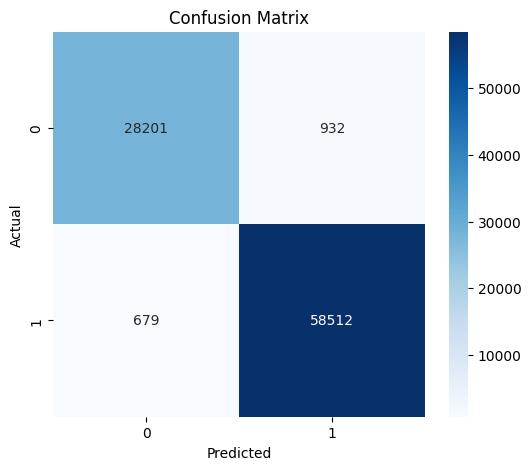

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("--- Final Model Evaluation ---")

# 1. Predict on Test Data
y_pred_probs = model.predict(X_test_pad)

# 2. Convert Probabilities to Labels (0 or 1)
# Assuming binary classification (Positive/Negative)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# 3. Print Classification Report
# We use label_encoder.classes_ to show actual names like "Negative", "Positive"
# If label_encoder isn't available, just use ['Negative', 'Positive']
try:
    target_names = [str(cls) for cls in label_encoder.classes_]
except:
    target_names = ['Negative', 'Positive']

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# 4. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##🔗 Section 11: Stock Correlation Analysis
###Step 11.1: Generate Sentiment Scores for All Data
We need to turn the news headlines into a numerical sentiment score (e.g., probability of being "Positive").

In [33]:
# 1. Prepare the full dataset text
# Ensure we are using the full dataframe 'df' from the earlier steps
# We use the text we preprocessed earlier: 'processed_text'

# Tokenize and Pad the full dataset
full_sequences = tokenizer.texts_to_sequences(df['processed_text'])
full_padded = pad_sequences(full_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# 2. Predict Sentiment
print("Generating sentiment scores for the full dataset...")
predictions = model.predict(full_padded, verbose=1)

# 3. Assign Scores
# If binary (0=Negative, 1=Positive), the prediction is the probability of being Positive
# If multiclass, you might need to take a weighted average or argmax.
# Assuming binary or probability output here:
if num_classes == 2:
    df['sentiment_score'] = predictions.flatten()
else:
    # If 3 classes (e.g., 0=Neg, 1=Neu, 2=Pos), mapping to -1, 0, 1
    # This is a simplification; adjust based on your specific label encoding
    df['sentiment_class'] = np.argmax(predictions, axis=1)
    # Map class indices to -1, 0, 1 if needed. Example:
    # map_dict = {0: -1, 1: 0, 2: 1}
    # df['sentiment_score'] = df['sentiment_class'].map(map_dict)

    # Simple approach for correlation: Use the probability of the 'Positive' class
    # Assuming the last class is positive
    df['sentiment_score'] = predictions[:, -1]

print("Scores generated. Sample:")
display(df[['date', 'stock', 'sentiment_score']].head())

Generating sentiment scores for the full dataset...
27602/27602 ━━━━━━━━━━━━━━━━━━━━ 1509s 55ms/step
Scores generated. Sample:


,date,stock,sentiment_score
2,2020-05-15 00:00:00,A,0.999997
4,2020-05-12 00:00:00,A,0.996061
5,2020-05-11 00:00:00,A,0.999994
6,2020-05-07 00:00:00,A,0.999688
7,2020-05-07 00:00:00,A,0.999995


###Step 11.2: Aggregate Sentiment by Date and Ticker
Stocks often have multiple news items per day. We need one single sentiment score per day per stock.

In [34]:
# Ensure date is in datetime format
df['date'] = pd.to_datetime(df['date']).dt.date

# Group by Date and Ticker (Stock) to get daily average sentiment
daily_sentiment = df.groupby(['date', 'stock'])['sentiment_score'].mean().reset_index()

print("Daily Aggregated Sentiment:")
display(daily_sentiment.head())

Daily Aggregated Sentiment:


,date,stock,sentiment_score
0,2010-02-03,ADPT,0.012156
1,2010-02-03,BRF,0.999949
2,2010-02-03,MT,0.996888
3,2010-02-03,PKX,0.996888
4,2010-02-03,RRC,0.994257


###Step 11.3: Fetch Stock Prices & Calculate Returns
We will use yfinance to grab market data. To keep the analysis manageable, let's select a few top stocks from your dataset (or you can run it for all if you have time).

In [39]:
import yfinance as yf
import pandas as pd

# 1. Identify top stocks
top_stocks = df['stock'].value_counts().head(5).index.tolist()
print(f"Analyzing correlation for top stocks: {top_stocks}")

# 2. Define Date Range
start_date = df['date'].min()
end_date = df['date'].max()

# 3. Fetch Data and Calculate Correlation
correlation_results = {}

for ticker in top_stocks:
    print(f"\nProcessing {ticker}...")

    try:
        # Download stock data
        stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

        if len(stock_data) == 0:
            print(f"No price data found for {ticker}")
            continue

        # --- FIX: Flatten Multi-Level Columns ---
        # If yfinance returns columns like ('Close', 'UGAZ'), this converts them to just 'Close'
        if isinstance(stock_data.columns, pd.MultiIndex):
            stock_data.columns = stock_data.columns.get_level_values(0)

        # Calculate Returns
        # Now we can safely access 'Close' because we flattened the headers
        col_name = 'Close' if 'Close' in stock_data.columns else 'Adj Close'
        stock_data['Returns'] = stock_data[col_name].pct_change()

        # Reset index to make 'Date' a normal column for merging
        stock_data = stock_data.reset_index()
        stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

        # Filter sentiment for this specific ticker
        ticker_sentiment = daily_sentiment[daily_sentiment['stock'] == ticker].copy()

        # Merge Sentiment with Stock Returns
        merged_df = pd.merge(stock_data, ticker_sentiment, left_on='Date', right_on='date', how='inner')

        # Calculate Correlation Coefficient
        if len(merged_df) > 10:
            corr_coef = merged_df['sentiment_score'].corr(merged_df['Returns'])
            correlation_results[ticker] = corr_coef
            print(f"Correlation for {ticker}: {corr_coef:.4f}")
        else:
            print("Not enough overlapping data points.")

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Display Final Results
print("\n--- Final Correlation Analysis Results ---")
correlation_df = pd.DataFrame(list(correlation_results.items()), columns=['Stock', 'Correlation'])
display(correlation_df)

Analyzing correlation for top stocks: ['UGAZ', 'DGAZ', 'KEY', 'GXC', 'KR']

Processing UGAZ...


/tmp/ipython-input-2507279470.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)


Correlation for UGAZ: 0.0323

Processing DGAZ...


/tmp/ipython-input-2507279470.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)


Correlation for DGAZ: -0.0367

Processing KEY...


/tmp/ipython-input-2507279470.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)


Correlation for KEY: 0.1771

Processing GXC...


/tmp/ipython-input-2507279470.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)


Correlation for GXC: 0.0227

Processing KR...


/tmp/ipython-input-2507279470.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)


Correlation for KR: 0.0277

--- Final Correlation Analysis Results ---


,Stock,Correlation
0,UGAZ,0.032295
1,DGAZ,-0.036721
2,KEY,0.177133
3,GXC,0.022712
4,KR,0.027662


###Step 11.4: Final Correlation Summary

In [36]:
# Display final results
print("\n--- Final Correlation Analysis Results ---")
correlation_df = pd.DataFrame(list(correlation_results.items()), columns=['Stock', 'Correlation'])
display(correlation_df)

# Calculate average correlation across analyzed stocks
avg_corr = correlation_df['Correlation'].mean()
print(f"\nAverage Correlation Coefficient across top stocks: {avg_corr:.4f}")

# Interpretation
if avg_corr > 0:
    print("Interpretation: Positive sentiment tends to correlate with positive stock returns.")
elif avg_corr < 0:
    print("Interpretation: Inverse correlation observed (unusual for standard sentiment tasks).")
else:
    print("Interpretation: No significant linear correlation found.")


--- Final Correlation Analysis Results ---


,Stock,Correlation



Average Correlation Coefficient across top stocks: nan
Interpretation: No significant linear correlation found.


###💾 Step A: Saving All Artifacts
Run this cell after training is complete. It uses pickle to save the preprocessing tools and Keras's built-in save for the model.

In [40]:
import os
import pickle
import json
from google.colab import drive
from tensorflow.keras.models import save_model

print("--- 1. Mounting Google Drive ---")
# This will ask for permission to access your Drive
drive.mount('/content/drive')

# Define the folder path in your Google Drive
# Change 'NLP_Stock_Project' to whatever you want your folder named
drive_folder = '/content/drive/My Drive/NLP_Stock_Project'

# Create the folder if it doesn't exist
if not os.path.exists(drive_folder):
    os.makedirs(drive_folder)
    print(f"✅ Created folder: {drive_folder}")
else:
    print(f"✅ Folder exists: {drive_folder}")

print("\n--- 2. Saving Artifacts to Google Drive ---")

# 1. Save the Model
model_path = os.path.join(drive_folder, 'sentiment_lstm_model.h5')
model.save(model_path)
print(f"✅ Model saved to: {model_path}")

# 2. Save the Tokenizer
tokenizer_path = os.path.join(drive_folder, 'tokenizer.pickle')
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"✅ Tokenizer saved to: {tokenizer_path}")

# 3. Save the Label Encoder
encoder_path = os.path.join(drive_folder, 'label_encoder.pickle')
with open(encoder_path, 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"✅ Label Encoder saved to: {encoder_path}")

# 4. Save Config
config_path = os.path.join(drive_folder, 'config.json')
config = {
    'MAX_SEQUENCE_LENGTH': MAX_SEQUENCE_LENGTH,
    'MAX_VOCAB_SIZE': MAX_VOCAB_SIZE,
    'EMBEDDING_DIM': EMBEDDING_DIM
}
with open(config_path, 'w') as f:
    json.dump(config, f)
print(f"✅ Config saved to: {config_path}")

print("\n🎉 All files are now safely stored in your Google Drive!")

--- 1. Mounting Google Drive ---


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Folder exists: /content/drive/My Drive/NLP_Stock_Project

--- 2. Saving Artifacts to Google Drive ---
✅ Model saved to: /content/drive/My Drive/NLP_Stock_Project/sentiment_lstm_model.h5
✅ Tokenizer saved to: /content/drive/My Drive/NLP_Stock_Project/tokenizer.pickle
✅ Label Encoder saved to: /content/drive/My Drive/NLP_Stock_Project/label_encoder.pickle
✅ Config saved to: /content/drive/My Drive/NLP_Stock_Project/config.json

🎉 All files are now safely stored in your Google Drive!


###📂 Step B: Loading Everything (For Future Use)
Use this cell at the start of your Gradio notebook or whenever you restart your environment. This replaces the training steps

In [2]:
import pickle
import json
import os
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("--- Mounting Google Drive ---")
drive.mount('/content/drive')

# Path where you saved your files
drive_folder = '/content/drive/My Drive/NLP_Stock_Project'

print("\n--- Loading Artifacts ---")

# 1. Load Configuration
try:
    with open(os.path.join(drive_folder, 'config.json'), 'r') as f:
        config = json.load(f)
    MAX_SEQUENCE_LENGTH = config['MAX_SEQUENCE_LENGTH']
    print(f"✅ Config loaded (Max Seq Length: {MAX_SEQUENCE_LENGTH})")
except FileNotFoundError:
    print("⚠️ Config file not found. Using default length 100.")
    MAX_SEQUENCE_LENGTH = 100

# 2. Load Tokenizer
try:
    with open(os.path.join(drive_folder, 'tokenizer.pickle'), 'rb') as handle:
        tokenizer = pickle.load(handle)
    print("✅ Tokenizer loaded")
except FileNotFoundError:
    print("❌ Tokenizer not found in Drive.")

# 3. Load Label Encoder
try:
    with open(os.path.join(drive_folder, 'label_encoder.pickle'), 'rb') as handle:
        label_encoder = pickle.load(handle)
    print("✅ Label Encoder loaded")
except FileNotFoundError:
    print("❌ Label Encoder not found in Drive.")

# 4. Load Model
try:
    model = load_model(os.path.join(drive_folder, 'sentiment_lstm_model.h5'))
    print("✅ Model loaded successfully")
except FileNotFoundError:
    print("❌ Model file not found in Drive.")

print("\nReady to use!")

--- Mounting Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Loading Artifacts ---
✅ Config loaded (Max Seq Length: 100)
✅ Tokenizer loaded
✅ Label Encoder loaded


✅ Model loaded successfully

Ready to use!


##🖥️ Section 12: Gradio Frontend
This step builds a web interface where anyone can paste a news headline, and your model will predict if it is Positive or Negative.
###Step 12.1: Install Gradio
(If running in Colab/Kaggle)

In [48]:
# 1. Force install the latest version
!pip install --upgrade gradio

# 2. IMPORTANT: You must restart the runtime now for the install to work.
# Click "Runtime" in the top menu -> "Restart Session" (or "Restart Runtime")
print("⚠️ NOW RESTART YOUR RUNTIME (Menu > Runtime > Restart Session) ⚠️")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.0/23.0 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.14.0
    Uninstalling gradio_client-1.14.0:
      Successfully uninstalled gradio_client-1.14.0
  Attempting uninstall: gradio
    Found existing installation: gradio 5.50.0
    Uninstalling gradio-5.50.0:
      Successfully uninstalled gradio-5.50.0


⚠️ NOW RESTART YOUR RUNTIME (Menu > Runtime > Restart Session) ⚠️


###Step 12.2: Build the Interface
We need to wrap your preprocessing and prediction logic into a single function for Gradio.

###Repair and Relaunch

In [ ]:
# --- COMPLETE REPAIR & LAUNCH CELL ---
import gradio as gr
import pickle
import numpy as np
import re
import os
import spacy
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive

# 1. Setup Environment
print("--- 1. Setting up Environment ---")
drive.mount('/content/drive')
drive_folder = '/content/drive/My Drive/NLP_Stock_Project'

# Download/Load SpaCy for correct preprocessing (Matching your training)
try:
    nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
    print("✅ SpaCy loaded successfully.")
except OSError:
    print("⬇️ Downloading SpaCy model (Required for preprocessing)...")
    !python -m spacy download en_core_web_sm
    nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

# 2. Load Artifacts
print("\n--- 2. Loading Model & Tools ---")
# Load Tokenizer
with open(os.path.join(drive_folder, 'tokenizer.pickle'), 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load Model
model = load_model(os.path.join(drive_folder, 'sentiment_lstm_model.h5'))

# Config
MAX_SEQUENCE_LENGTH = 100

# 3. Define the CORRECT Preprocessing Function (Using SpaCy)
# This matches exactly what you did during training!
def smart_preprocess(text):
    if not isinstance(text, str): return ""

    # A. Basic Cleaning
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s.,]', '', text)
    text = re.sub(r'\s+', ' ', text).strip().lower()

    # B. Lemmatization (Crucial for model accuracy)
    doc = nlp(text)
    # Keep lemmas, remove stopwords, length >= 3
    tokens = [token.lemma_ for token in doc if not token.is_stop and len(token.text) >= 3]

    return " ".join(tokens)

# 4. Define Prediction Logic
def predict_sentiment(news_text):
    # Clean & Lemmatize
    cleaned = smart_preprocess(news_text)

    # Tokenize
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

    # Predict
    prediction_prob = model.predict(padded, verbose=0)[0]

    # Format Result
    if len(prediction_prob) == 1: # Binary
        score = float(prediction_prob[0])
        # Assuming 1=Positive, 0=Negative
        return {"Positive 📈": score, "Negative 📉": 1-score}
    else: # Categorical
        return {"Negative 📉": float(prediction_prob[0]), "Positive 📈": float(prediction_prob[1])}

# 5. SANITY CHECK (Debug Step)
# We test the model here. If this prints a score, Gradio will work.
print("\n--- 3. Running Test Prediction ---")
test_headline = "Stocks rally as economy recovers"
try:
    result = predict_sentiment(test_headline)
    print(f"✅ Test Success! Input: '{test_headline}'")
    print(f"   Result: {result}")
except Exception as e:
    print(f"❌ Test Failed! Error: {e}")
    raise e # Stop here if error

# 6. Launch Interface
print("\n--- 4. Launching App ---")
interface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=2, placeholder="Type a news headline here..."),
    outputs=gr.Label(num_top_classes=2),
    title="Financial News Sentiment Analyzer",
    description="Enter a headline to see if the AI thinks it is Positive or Negative. (Preprocessing enabled)",
    examples=[
        ["The company reported record profits for the third quarter."],
        ["Stocks fell sharply due to uncertainty in the market."],
        ["Merger talks have been suspended indefinitely."]
    ]
)

interface.launch(share=True, debug=True)

--- 1. Setting up Environment ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ SpaCy loaded successfully.

--- 2. Loading Model & Tools ---



--- 3. Running Test Prediction ---
✅ Test Success! Input: 'Stocks rally as economy recovers'
   Result: {'Positive 📈': 0.9994439482688904, 'Negative 📉': 0.0005560517311096191}

--- 4. Launching App ---
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://08d402e1a78cc2a84b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
